#Chemical similarity search in MongoDB

### myChEMBL team, ChEMBL group, EMBL-EBI.

##What is this?

This IPython Notebook is intended to provide an overview of how to perform time efficient chemical searches in MongoDB. It is based on the [blog post](http://blog.matt-swain.com/post/87093745652/chemical-similarity-search-in-mongodb) by Matt Swain.

Some necessary imports first. Here we import some Python core libraries, IPython utilities and plotting helpers.

In [1]:
%matplotlib inline
%pylab inline
from IPython.display import Image
from IPython.html.widgets import FloatProgress
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import random
import time
import sys
import os
from itertools import groupby

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


We are using RDKit for all chemoinformatics calculations:

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

For connecting to ChEMBL database we will use Django ORM, described in [notebook 08](https://github.com/chembl/mychembl/blob/master/ipython_notebooks/08_myChEMBL_Django_ORM.ipynb). We have to import ChEMBL Django model as well:

In [3]:
sys.path.append('/home/chembl/ipynb_workbench')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "settings")
import chembl_migration_model
from chembl_migration_model.models import *
from chembl_core_model.models import CompoundMols

For connecting to mongoDB we will use pymongo.

In [4]:
import pymongo
from bson.binary import Binary
from bson.objectid import ObjectId
from pymongo import MongoClient

Here we establish connection with mongoDB and create a new database called 'similarity':

In [5]:
client = MongoClient()
db = client.similarity

## Populating the MongoDB database

Our first task will be to retrieve all compounds from ChEMBL and insert them to MongoDB collection. For each compound in ChEMBL we will select its CHEMBL ID and SMILES string, we will use Django ORM to retrieve this data like this:

In [6]:
smiles = MoleculeDictionary.objects.values_list('compoundstructures__canonical_smiles', 'chembl_id')
smi_count = smiles.count()

If the molecules are already loaded we won't do anything. Otherwise we will iterate over all compounds in ChEMBL and use RDKit to create a binary object (we will use it later to compute fingerprints) and SMILES (RDKit uses different algorithm for generating SMILES than the one used at ChEMBL). There are some compounds in ChEMBL db, which current can't be handled by RDKit, this is why we are using `try`/`except` blocks. It is not good practice to catch all exceptions (having single `except` keyword is called pockemon exception handling) but this is not mission critical code. So for each compound we will store a document containing SMILES, RDKit object and CHEMBL ID.

In [13]:
if 'molecules' not in db.collection_names():
    print 'populating mongodb collection with compounds from chembl...'
    sys.stdout.flush()
    molecules = db.molecules
    percentile = int(smi_count / 100)
    pbar = FloatProgress(min=0, max=smi_count)
    display(pbar)
    chunk_size = 100
    chunk = []
    for i, item in enumerate(smiles):
        if not (i % percentile):
            pbar.value = (i + 1)
        try:
            rdmol = Chem.MolFromSmiles(item[0])
        except:
            continue
        if not rdmol:
            continue
        mol_data = {
            'smiles': Chem.MolToSmiles(rdmol, isomericSmiles=True),
            'chembl_id': item[1],
            'rdmol': Binary(rdmol.ToBinary()),
        }
        chunk.append(mol_data)
        if len(chunk) == chunk_size:
            molecules.insert_many(chunk)
            chunk = []
    molecules.insert_many(chunk)
    chunk = []        
    pbar.value = smi_count
    print '%s molecules loaded successfully' % molecules.count()

populating mongodb collection with compounds from chembl...
1455713 molecules loaded successfully


## Chemical similarity basics

In practice, efficient calculation of the [similarity](https://en.wikipedia.org/wiki/Chemical_similarity) of any two molecules is achieved using molecular fingerprints that encode structural information about the molecule as a series of bits (0 or 1). Typically these bits represent the presence or absence of particular patterns or substructures — two molecules that contain more of the same patterns will have more bits in common, indicating that they are more similar. The most commonly used measure for quantifying the similarity of two fingerprints is the [Tanimoto (a.k.a. Jaccard) coefficient](https://en.wikipedia.org/wiki/Jaccard_index), given by:

$$T = \frac{N_{ab}}{N_{a} + N_{b} - N_{ab}}$$

where $N_{a}$ and $N_{b}$ are the number of ‘on’ fingerprint bits (i.e corresponding to the presence of a pattern) in the fingerprints of molecule $a$ and molecule $b$ respectively. $N_{ab}$ is the number of fingerprint bits common to the fingerprints of both molecule $a$ and $b$. The Tanimoto coefficient ranges from 0 when the fingerprints have no bits in common, to 1 when the fingerprints are identical.

##Generating fingerprints

[Morgan (a.k.a. circular) fingerprints](http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints) are an [ECFP](http://pubs.acs.org/doi/abs/10.1021/ci100050t)-like family of fingerprints that RDKit can generate. Instead of being based on bits that correspond to a fixed set of predefined substructural keys, ECFPs consist of integer codes that are generated using a hashing procedure from the local environments around each atom in multiple circular layers up to a given radius. Given a radius (e.g. 2), RDKit will return a Morgan fingerprint as a count vector that consists of a list of unique integers codes, each with a count that corresponds to the number of times the corresponding substructure occurs in the molecule:

    mfp = AllChem.GetMorganFingerprint(rdmol, 2)

While this is the most information-rich representation of this fingerprint, there are two things to note:

Firstly, each fingerprint consists of typically less than 100 integer codes that are sparsely mapped over a vast space of $2^{32}$ possible integers. Storing these in the database as explicit bit vectors would be hugely inefficient and impractical (even impossible?), so RDKit also has the ability to fold the fingerprints down to a fixed length bit vector. Fortunately, for our purposes it is actually preferable to store the fingerprints in MongoDB as an array of just the ‘on’ bit positions, negating most of the problems with sparse fingerprints and making it possible to use unfolded fingerprints. Nevertheless, it is worth investigating the impact that folding has on both query performance and quality of the query results.

Secondly, it’s worth considering how best to use the count information associated with each integer code. For now, we have just discarded this information and treated the fingerprint as a traditional on/off bit vector. However, it shouldn’t be too difficult to retain and use this information when calculating similarities. We expect this could improve the quality of the query results, but could potentially have a negative impact on query performance.

It's important to pre-calculate the fingerprint for every molecule in the database so it doesn’t have to be redundantly calculated every time a search is performed, we can append fingerprint information to each document in the `molecules` collection:

In [18]:
print 'precalculating fingerprints...'
sys.stdout.flush()
mol_count = molecules.count()
percentile = int(mol_count / 100)
pbar = FloatProgress(min=0, max=mol_count)
display(pbar)
for i, molecule in enumerate(db.molecules.find()):
    if not (i % percentile):
        pbar.value = (i + 1)
    rdmol = Chem.Mol(molecule['rdmol'])
    mfp = list(AllChem.GetMorganFingerprintAsBitVect(rdmol, 2, nBits=2048).GetOnBits())
    db.molecules.update_one({'_id': molecule['_id']}, {"$set":{"mfp":{'bits': mfp, 'count': len(mfp)}}} )
pbar.value = mol_count    
print '...done'

precalculating fingerprints...
...done


Figure below shows the distribution of the number of ‘on’ bits in the fingerprint for each molecule calculated for the entire ChEMBL database. Folded fingerprints show similar distributions, but with slightly lower mean values due to collisions where two or more different integer codes get folded onto the same bit position in the smaller fixed range.

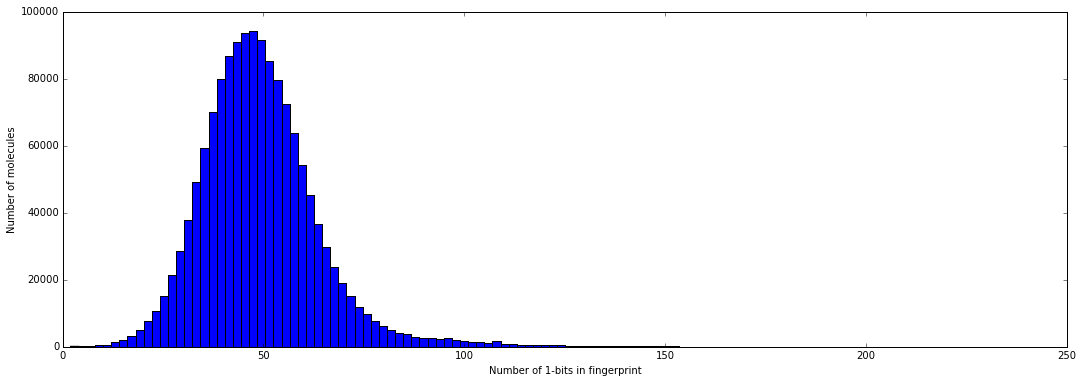

In [84]:
response = db.molecules.aggregate([{'$group': {'_id': '$mfp.count', 'total': {'$sum': 1}}}])
data = pd.DataFrame().from_dict([r for r in response])
fig = plt.figure()
fig.set_size_inches(18, 6)
plt.ylabel('Number of molecules')
plt.xlabel('Number of 1-bits in fingerprint')
h = plt.hist(data._id, weights=data.total, histtype='bar', bins=105, rwidth=2)

For each molecule in our collection we will also store the total number of bits in the fingerprint (i.e. $N_{b}$, needed to calculate the Tanimoto coefficient). The code below produces a collection called `mfp_counts` with documents that have a count field and an `_id` that corresponds to the fingerprint bit.

In [85]:
print 'computing fingerprint bit counts...'
sys.stdout.flush()
counts = {}
mol_count = molecules.count()
percentile = int(mol_count / 100)
pbar = FloatProgress(min=0, max=mol_count)
display(pbar)
for molecule in db.molecules.find():
    if not (i % percentile):
        pbar.value = (i + 1)
    for bit in molecule['mfp']['bits']:
        counts[bit] = counts.get(bit, 0) + 1

counts_it = counts.items()
chunk_size = 100
for chunk in [counts_it[i:i + chunk_size] for i in range(0, len(counts_it), chunk_size)]:
    db.mfp_counts.insert_many([{'_id': k, 'count': v} for k,v in chunk])
pbar.value = mol_count    
print '... done'    

computing fingerprint bit counts...
... done


MongoDB query performance can be further improved by adding an index on the specific fields that will be queried, in this case the fingerprint bits and counts:

In [20]:
db.molecules.create_index('mfp.bits')
db.molecules.create_index('mfp.count')

u'mfp.count_1'

There are two further efficiency tricks that work by placing constraints on easily searchable properties of fingerprints to filter out the most obviously unsuitable molecules before going through the expensive process of calculating the exact Tanimoto coefficient:

1. Given a query fingerprint with $N_{a}$ bits, any molecule in the database must have $N_{b}$ bits within the range $TN_{a} \leqslant N_{b} \leqslant \frac{N_{a}}{T}$ to have a similarity above a threshold $T$. This is because if the number of bits in each fingerprint differ by too much, it would be impossible for the similarity to be above the threshold even in the most ideal case where one fingerprint is an exact subset of the other.

2. Out of any $N_{a} - TN_{a} + 1$ bits chosen at random from the query fingerprint $a$, at least one must be present in any other fingerprint $b$ to achieve a similarity above the threshold $T$. This is because even if all the remaining other $TN_{a} - 1$ bits are in common, it still would not be enough for the similarity to be above the threshold (as shown by the previous constraint).

For the second constraint, the bits chosen from the query fingerprint don’t actually need to be random — in fact, we can optimise even further by ensuring we choose the rarest fingerprint bits, thus restricting the query set as much as possible.

In [21]:
def similarity_client(smiles, threshold=0.8):
    """Perform a similarity search on the client, with initial screening to improve performance."""
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return
    qfp = list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048).GetOnBits())
    qn = len(qfp)                           # Number of bits in query fingerprint
    qmin = int(ceil(qn * threshold))        # Minimum number of bits in results fingerprints
    qmax = int(qn / threshold)              # Maximum number of bits in results fingerprints
    ncommon = qn - qmin + 1                 # Number of fingerprint bits in which at least one must be in common
    # Get list of bits where at least one must be in result fp. Use least popular bits if possible.
    if db.mfp_counts:
        reqbits = [count['_id'] for count in db.mfp_counts.find({'_id': {'$in': qfp}}).sort('count', 1).limit(ncommon)]
    else:
        reqbits = qfp[:ncommon]
    results = []
    for fp in db.molecules.find({'mfp.bits': {'$in': reqbits}, 'mfp.count': {'$gte': qmin, '$lte': qmax}}):
        intersection = len(set(qfp) & set(fp['mfp']['bits']))
        pn = fp['mfp']['count']
        tanimoto = float(intersection) / (pn + qn - intersection)
        if tanimoto >= threshold:
            results.append((tanimoto, fp['chembl_id'], fp['smiles']))
    return results

Just checking how it works for aspirin...

In [22]:
# aspirin
similarity_client('O=C(Oc1ccccc1C(=O)O)C')

[(1.0, u'CHEMBL25', u'CC(=O)Oc1ccccc1C(=O)O'),
 (0.8571428571428571, u'CHEMBL350343', u'CC(=O)Oc1ccccc1C(=O)Oc1ccccc1C(=O)O')]

## The MongoDB aggregation framework

One issue with the query method outlined above is that most of the time-consuming work is performed by the client rather than the database server. The server performs the initial filtering stages and then just sends thousands of molecules over to the client to calculate the exact similarities and produce the actual results. This makes the overall performance mostly dependent on the speed of the client or application server; it also has the potential for a network bottleneck when transferring such a huge amount of data for each query.

The solution to this problem is to use the MongoDB aggregation framework, which allows a pipeline of tasks to be performed on the MongoDB server. This way, the MongoDB server does all the work and only the actual query results are sent to the client.

In his [blog post at Datablend](http://datablend.be/?p=265), Davy proposed an aggregation pipeline for similarity searching that Rajarshi found to be disappointingly slow in [his benchmarks](http://blog.rguha.net/?p=1261). However, in the time since Davy wrote his blog post, MongoDB version 2.6 introduced some new aggregation features that may have better performance. Of particular interest is the `$setIntersection` operator, which is exactly what we need to calculate the number of bits in common between two fingerprints.

Here’s a similarity search aggregation pipeline that uses these new features: 

In [7]:
def similarity_search_fp(smiles, threshold=0.8):
    """Perform a similarity search using aggregation framework."""
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return
    qfp = list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048).GetOnBits())    
    qn = len(qfp)                           # Number of bits in query fingerprint
    qmin = int(ceil(qn * threshold))        # Minimum number of bits in results fingerprints
    qmax = int(qn / threshold)              # Maximum number of bits in results fingerprints
    ncommon = qn - qmin + 1                 # Number of fingerprint bits in which at least 1 must be in common
    if db.mfp_counts:
        reqbits = [count['_id'] for count in db.mfp_counts.find({'_id': {'$in': qfp}}).sort('count', 1).limit(ncommon)]
    else:
        reqbits = qfp[:ncommon]
    aggregate = [
        {'$match': {'mfp.count': {'$gte': qmin, '$lte': qmax}, 'mfp.bits': {'$in': reqbits}}},
        {'$project': {
            'tanimoto': {'$let': {
                'vars': {'common': {'$size': {'$setIntersection': ['$mfp.bits', qfp]}}},
                'in': {'$divide': ['$$common', {'$subtract': [{'$add': [qn, '$mfp.count']}, '$$common']}]}
            }},
        'smiles': 1,
        'chembl_id': 1
        }},
        {'$match': {'tanimoto': {'$gte': threshold}}}
    ]
    response = db.molecules.aggregate(aggregate)
    return [(r['tanimoto'], r['smiles'], r['chembl_id']) for r in response]

Checking improved function with aspirin:

In [10]:
similarity_search_fp('O=C(Oc1ccccc1C(=O)O)C')

[(1.0, u'CC(=O)Oc1ccccc1C(=O)O', u'CHEMBL25'),
 (0.8571428571428571, u'CC(=O)Oc1ccccc1C(=O)Oc1ccccc1C(=O)O', u'CHEMBL350343')]

## Benchmarks

In order to perform benchmarks we will select 1000 random compound SMILES from ChEMBL. Note, that because in MongoDB collection we stored RDKit-generated SMILES, in most cases result SMILES will differ. For each discrete value of threshold, we will perform the same benchmark 5 times and save mean value.

In [11]:
sample_size = 1000
rand_smpl = [ smiles[i][0] for i in sorted(random.sample(xrange((smiles.count())), sample_size)) ]
repetitions = 5

We are now ready to run actual benchmarks. This can take several hours to compute, depending on hardware.

In [42]:
timings = []
for thresh in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    print 'measuring performance for similarity {0}'.format(thresh)
    sys.stdout.flush()
    rep_times = []
    for i in range(repetitions):
        start = time.time()
        for sample in rand_smpl:
            _ = similarity_search_fp(sample, thresh)
        stop = time.time()
        rep_times.append(stop-start)
    timings.append((thresh, np.mean(rep_times)))

measuring performance for similarity 0.7
measuring performance for similarity 0.75
measuring performance for similarity 0.8
measuring performance for similarity 0.85
measuring performance for similarity 0.9
measuring performance for similarity 0.95


Once this is complete, we can take a look at results:

In [14]:
print timings

[(0.7, 2959.67804813385), (0.75, 2161.8768181800842), (0.8, 1224.4110579490662), (0.85, 625.453076839447), (0.9, 298.62185406684875), (0.95, 74.62168312072754)]


Plotting them will give us a better idea about time complexity:

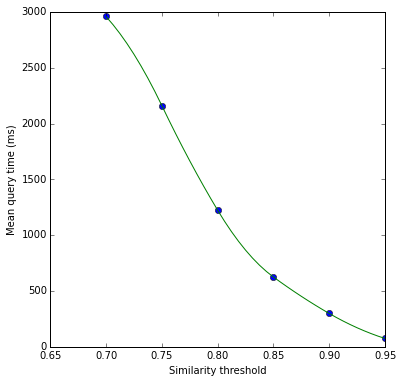

In [87]:
thresholds = np.array([t[0] for t in reversed(timings)])
times = np.array([t[1] for t in reversed(timings)])
fig = plt.figure()
fig.set_size_inches(6, 6)
xnew = np.linspace(thresholds.min(), thresholds.max(), num=41, endpoint=True)
f2 = interp1d(thresholds, times, kind='quadratic')
plt.plot(thresholds, times, 'o', xnew, f2(xnew), '-')
plt.ylabel('Mean query time (ms)')
plt.xlabel('Similarity threshold')
plt.show()


Although this looks better than benchmarks performed by Rajarshi Guha, it's still disappointing. Apart from very high threshold values, all other data points indicate very long query times. The overall shape of the curve indicates polynomial time complexity with respect to decreasing threshold.

It's worth noting, that the results presented on the chart above are actually higher then original results presented by Matt Swain. This is most probably because Matt [defined functions](https://github.com/mcs07/mongodb-chemistry/blob/master/mchem/profile.py#L26) with a signatures like this:

    profile_similarity(mols, fingerprinter, fp_collection, result_collection, threshold=0.8, count_collection=None)
    
So expecting binary RDKit mol object while all similarity functions defined in this notebook have signature like:

    similarity_search_fp(smiles, threshold=0.8)
    
So expecting SMILES string as input. This require additional expensive step of parsing SMILES string and converting it to RDKit mol. The second form is much more useful in practical applications.

## Introducing Locality-sensitive hashing

Basically the problem of finding similar compounds is a variation of nearest neighbour search. One of the methods that are helpful in solving this kind of problem is called [Locality-sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing).

The idea behind LSH is pretty simple - while most hashes we use everyday ([cryptographic hashes](https://en.wikipedia.org/wiki/Cryptographic_hash_function) like [SHA](https://en.wikipedia.org/wiki/Secure_Hash_Algorithm)) generate completely different values for documents even when they differ only slightly, LSH tries to generate similar hash values for similar documents, so to maximize the probability of [hash collision](https://en.wikipedia.org/wiki/Collision_%28computer_science%29).

Since we are using Tanimoto coefficient for measuring similarity, it makes sense to use min-wise independent permutations locality sensitive hashing scheme. In fact, even the very short [Wikipedia article](https://en.wikipedia.org/wiki/Jaccard_index) about Tanimoto (Jaccard) index, mentions [MinHash](https://en.wikipedia.org/wiki/MinHash) as an algorithm that "may be used to efficiently compute an accurate estimate of the Jaccard similarity coefficient of pairs of sets".

## Improving time complexity using MinHash

In order to define new version of similarity search based on LSH we need to define some functions. We ported them from the code presented in [article by Ciumac Sergiu](http://www.codeproject.com/Articles/206507/Duplicates-detector-via-audio-fingerprinting#worksinspiration). They generate random permutations, reorder fingerprint bits according to permutations and save the position of the first '1' bit in reordered fingerprints. Then compress the list of the '1' position into smaller list by composing one bigger number from several smaller using binary left shift operation.

In [51]:
def get_permutations(len_permutations=2048, num_permutations=100):
    return map(lambda _: np.random.permutation(2048), range(num_permutations))

def get_min_hash(mol, permutations):
    qfp_bits = [int(n) for n in AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)]
    min_hash = []
    for perm in permutations:
        for idx, i in enumerate(perm):
            if qfp_bits[i]:
                min_hash.append(idx)
                break            
    return min_hash

def hash_to_buckets(min_hash, num_buckets=25, nBits=2048):
    if len(min_hash) % num_buckets:
        raise Exception('number of buckets must be divisiable by the hash length')
    buckets = []
    hash_per_bucket = int(len(min_hash) / num_buckets)
    num_bits = (nBits-1).bit_length()
    if num_bits * hash_per_bucket > sys.maxint.bit_length():
        raise Exception('numbers are too large to produce valid buckets')
    for b in range(num_buckets):
        buckets.append(reduce(lambda x,y: (x << num_bits) + y, min_hash[b:(b + hash_per_bucket)]))
    return buckets
        

We can now generate some random permutations and save them to the separate MongoDB collection: 

In [131]:
db.permutations.insert_many([{'_id':i, 'permutation': perm.tolist()} for i, perm in enumerate(get_permutations())])

Having our permutations, we can precompute locality-sensitive hashes for each molecule and add them to molecule document:

In [248]:
permutations = [p['permutation'] for p in db.permutations.find()]
print 'precalculating locality-sensitive hashing groups...'
sys.stdout.flush()
mol_count = db.molecules.count()
percentile = int(mol_count / 100)
pbar = FloatProgress(min=0, max=mol_count)
display(pbar)
for i, molecule in enumerate(db.molecules.find()):
    if not (i % percentile):
        pbar.value = (i + 1)
    rdmol = Chem.Mol(molecule['rdmol'])
    min_hash = get_min_hash(rdmol, permutations)
    hash_groups = hash_to_buckets(min_hash)
    db.molecules.update_one({'_id': molecule['_id']}, {"$set":{"lsh" : hash_groups}} )
pbar.value = mol_count    
print '...done'

precalculating locality-sensitive hashing groups...
...done


Now we can use generated hashes to create inverted indexes - 25 separate collection storing documents indexed by hash and having a list of documents as a value. It's worth noting that we could generate hashes and store them in inverted indexes in one step, instead of writing uncompressed and compressed hashes to molecules documents. This would certainly reduce the time required to complete all preparations but we would like to investigate further in the future.

In [366]:
print 'constructing hash maps...'
sys.stdout.flush()
mol_count = db.molecules.count()
percentile = int(mol_count / 100)
pbar = FloatProgress(min=0, max=mol_count)
display(pbar)
for i, molecule in enumerate(db.molecules.find()):
    if not (i % percentile):
        pbar.value = (i + 1)
    hash_groups = molecule["lsh"]
    for n_hash, lsh_hash in enumerate(hash_groups):
        db['hash_' + str(n_hash)].update_one({'_id':lsh_hash}, {'$push':{'molecules': molecule['_id']}}, True)
pbar.value = mol_count
print '...done'

constructing hash tables...
...done


After completing all those preliminary steps we can finally define our new `similarity_search_lsh` function:

In [52]:
#permutations = [p['permutation'] for p in db.permutations.find()]

def similarity_search_lsh(smiles, threshold=0.8):
    """Perform a similarity search using aggregation framework."""
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    qfp = list(fp.GetOnBits())
    qfp_bits = [int(n) for n in fp]
    min_hash = []
    for perm in permutations:
        for idx, i in enumerate(perm):
            if qfp_bits[i]:
                min_hash.append(idx)
                break
    hash_groups = hash_to_buckets(min_hash)    
    qn = len(qfp)                           # Number of bits in query fingerprint
    qmin = int(ceil(qn * threshold))        # Minimum number of bits in results fingerprints
    qmax = int(qn / threshold)              # Maximum number of bits in results fingerprints
    ncommon = qn - qmin + 1                 # Number of fingerprint bits in which at least 1 must be in common
    if db.mfp_counts:
        reqbits = [count['_id'] for count in db.mfp_counts.find({'_id': {'$in': qfp}}).sort('count', 1).limit(ncommon)]
    else:
        reqbits = qfp[:ncommon]
    
    nested_res = [ list(i)[0]['molecules'] for i in 
            [db['hash_' + str(i)].find({'_id':h},{'molecules':1}) for i,h in enumerate(hash_groups)]]
    
    hashed_ids = [ObjectId(x) for x in (set([str(item) for sublist in nested_res for item in sublist]))]
    aggregate = [
        {'$match': {'_id':{'$in': hashed_ids}, 'mfp.count': {'$gte': qmin, '$lte': qmax}, 'mfp.bits': {'$in': reqbits}}},
        {'$project':{            
         'tanimoto': {'$let': {
                'vars': {'common': {'$size': {'$setIntersection': ['$mfp.bits', qfp]}}},
                'in': {'$divide': ['$$common', {'$subtract': [{'$add': [qn, '$mfp.count']}, '$$common']}]}
            }},
        'smiles': 1,
        'chembl_id': 1}},
        {'$match': {'tanimoto': {'$gte': threshold}}},
    ]
    response = db.molecules.aggregate(aggregate)
    return [(r['tanimoto'], r['smiles'], r['chembl_id']) for r in response]

Traditionally, checking results for aspirin:

In [53]:
similarity_search_lsh('O=C(Oc1ccccc1C(=O)O)C')

[(1.0, u'CC(=O)Oc1ccccc1C(=O)O', u'CHEMBL25'),
 (0.8571428571428571, u'CC(=O)Oc1ccccc1C(=O)Oc1ccccc1C(=O)O', u'CHEMBL350343')]

## Benchmarks

In order to check the performance of our `similarity_search_lsh` function, we will use the same set of 1000 compounds we were using to test `similarity_search_fp`.

In [62]:
timings_lsh = []
for thresh in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]: #[0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    print 'measuring performance for similarity {0}'.format(thresh)
    sys.stdout.flush()
    rep_times = []
    for i in range(repetitions):
        start = time.time()
        for sample in rand_smpl:
            _ = similarity_search_lsh(sample, thresh)
        stop = time.time()
        rep_times.append(stop-start)
    timings_lsh.append((thresh, np.mean(rep_times)))

measuring performance for similarity 0.7
measuring performance for similarity 0.75
measuring performance for similarity 0.8
measuring performance for similarity 0.85
measuring performance for similarity 0.9
measuring performance for similarity 0.95


In [11]:
timings_lsh

[(0.7, 108.79886355400086),
 (0.75, 106.44789280891419),
 (0.8, 95.1254898071289),
 (0.85, 90.56010603904724),
 (0.9, 84.14158177375793),
 (0.95, 77.25984625816345)]

Plotting the results...

[(0.7, 108.79886355400086), (0.75, 106.44789280891419), (0.8, 95.1254898071289), (0.85, 90.56010603904724), (0.9, 84.14158177375793), (0.95, 77.25984625816345)]
[  77.25984626   84.14158177   90.56010604   95.12548981  106.44789281
  108.79886355]


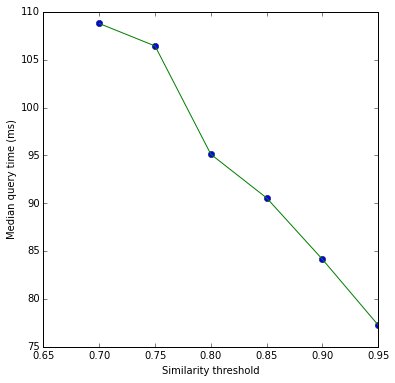

In [24]:
thresholds = np.array([t[0] for t in reversed(timings_lsh)])
times = np.array([t[1] for t in reversed(timings_lsh)])
print timings_lsh
print times
fig = plt.figure()
fig.set_size_inches(6, 6)
xnew = np.linspace(thresholds.min(), thresholds.max(), num=41, endpoint=True)
f2 = interp1d(thresholds, times, kind='slinear')
plt.plot(thresholds, times, 'o', xnew, f2(xnew), '-')
plt.ylabel('Median query time (ms)')
plt.xlabel('Similarity threshold')
plt.show()

This looks way better than the time complexity of `similarity_search_fp` but we will check them both on the same plot later...

## Accuracy

We can check how accurate is function `similarity_search_lsh` when compared to `similarity_search_fp`. We will check number of discrepancies defined as the size of symmetrical [set difference](https://docs.python.org/2/library/sets.html#set-objects) between results from both functions. We will measure total number of discrepancies over a set of 1000 random compounds as a function of similarity threshold.

In [ ]:
discrepancies = []
discrepancies_details = []
for thresh in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]: #[0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    print 'measuring discrepancies for similarity {0}'.format(thresh)
    sys.stdout.flush()
    rep_discrepancies = []
    for i in range(repetitions):
        dis_sum = 0
        for sample in rand_smpl:
            sim_lsh = similarity_search_lsh(sample, thresh)
            sim_fp = similarity_search_fp(sample, thresh)
            lsh_res = set([x[2] for x in sim_lsh if (x and len(x) > 2)]) if sim_lsh else set()
            reg_res = set([x[2] for x in sim_fp if (x and len(x) > 2)]) if sim_fp else set()
            difference = (lsh_res^reg_res)
            dis_sum += len(difference)
            discrepancies_details.append((sample, thresh, difference))
        rep_discrepancies.append(dis_sum)
    discrepancies.append((thresh, np.mean(rep_discrepancies)))

measuring discrepancies for similarity 0.7


In [8]:
print discrepancies

[(0.7, 153.0), (0.75, 37.0), (0.8, 1.0), (0.85, 0.0), (0.9, 0.0), (0.95, 0.0)]


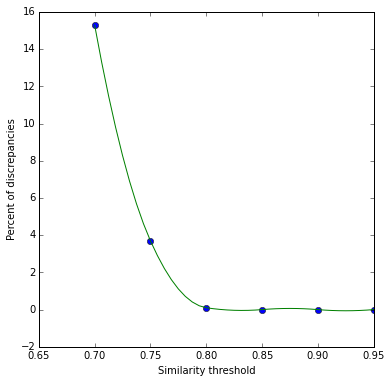

In [9]:
thresholds = np.array([t[0] for t in reversed(discrepancies)])
errors = np.array([t[1] / 10.0 for t in reversed(discrepancies)])
fig = plt.figure()
fig.set_size_inches(6, 6)
xnew = np.linspace(thresholds.min(), thresholds.max(), num=41, endpoint=True)
f2 = interp1d(thresholds, errors, kind='quadratic')
plt.plot(thresholds, errors, 'o', xnew, f2(xnew), '-')
plt.ylabel('Percent of discrepancies')
plt.xlabel('Similarity threshold')
plt.show()

From threshold 0.8 and more there are almost no discrepancies. The highest number of differences is for 0.7 - there are some discrepancies in results for 16% of compounds.

## Comparing with different methods

We are now ready to compare the time complexity of `similarity_search_lsh` function and `similarity_search_fp` on a single chart.

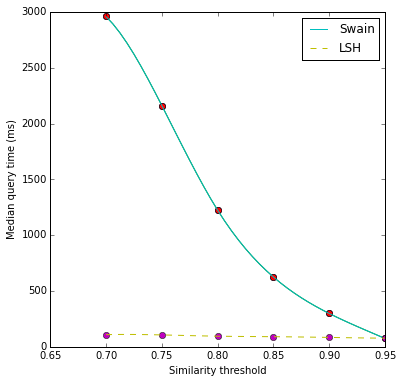

In [15]:
thresholds = np.array([t[0] for t in reversed(timings)])
times = np.array([t[1] for t in reversed(timings)])
fig = plt.figure()
fig.set_size_inches(6, 6)
xnew = np.linspace(thresholds.min(), thresholds.max(), num=41, endpoint=True)
f2 = interp1d(thresholds, times, kind='cubic')
plt.plot(thresholds, times, 'o', xnew, f2(xnew), '-')

thresholds_lsh = np.array([t[0] for t in reversed(timings_lsh)])
times_lsh = np.array([t[1] for t in reversed(timings_lsh)])
xnew_lsh = np.linspace(thresholds_lsh.min(), thresholds_lsh.max(), num=41, endpoint=True)
f3 = interp1d(thresholds_lsh, times_lsh, kind='cubic')

_, swain = plt.plot(thresholds, times, 'o', xnew, f2(xnew), '-')
_, lsh = plt.plot(thresholds_lsh, times_lsh, 'o', xnew_lsh, f3(xnew_lsh), '--')
plt.legend([swain, lsh], ['Swain', 'LSH'])
plt.ylabel('Median query time (ms)')
plt.xlabel('Similarity threshold')
plt.show()

To make this comparison complete, we can include time results for RDKit postgreSQL cartridge as well. Here we will use Django ORM, which will call the cartridge:

In [67]:
repetitions = 1
timings_cartrdge = []
for thresh in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    print 'measuring performance for similarity {0}'.format(thresh)
    sys.stdout.flush()
    rep_times = []
    for i in range(repetitions):
        start = time.time()
        for sample in rand_smpl:
            _ = len(CompoundMols.objects.similar_to(sample, int(thresh * 100)).values_list('molecule_id', 'similarity'))
        stop = time.time()
        rep_times.append(stop-start)
    timings_cartrdge.append((thresh, np.mean(rep_times)))

measuring performance for similarity 0.9
measuring performance for similarity 0.95


In [17]:
timings_cartrdge

[(0.7, 1153.354385995865),
 (0.75, 1223.412336397171),
 (0.8, 1194.9570102214814),
 (0.85, 1228.4131727695465),
 (0.9, 1115.4482998847961),
 (0.95, 1162.2547509670258)]

We can now plot all three curves:

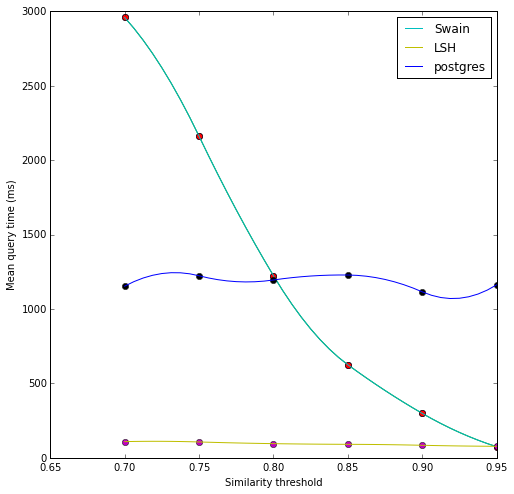

In [18]:
thresholds = np.array([t[0] for t in reversed(timings)])
times = np.array([t[1] for t in reversed(timings)])
fig = plt.figure()
fig.set_size_inches(8, 8)
xnew = np.linspace(thresholds.min(), thresholds.max(), num=41, endpoint=True)
f2 = interp1d(thresholds, times, kind='quadratic')
plt.plot(thresholds, times, 'o', xnew, f2(xnew), '-')

thresholds_lsh = np.array([t[0] for t in reversed(timings_lsh)])
times_lsh = np.array([t[1] for t in reversed(timings_lsh)])
xnew_lsh = np.linspace(thresholds_lsh.min(), thresholds_lsh.max(), num=41, endpoint=True)
f3 = interp1d(thresholds_lsh, times_lsh, kind='quadratic')

thresholds_car = np.array([t[0] for t in reversed(timings_cartrdge)])
times_car = np.array([t[1] for t in reversed(timings_cartrdge)])
xnew_car = np.linspace(thresholds_car.min(), thresholds_car.max(), num=41, endpoint=True)
f4 = interp1d(thresholds_car, times_car, kind='quadratic')

_, swain = plt.plot(thresholds, times, 'o', xnew, f2(xnew), '-')
_, lsh = plt.plot(thresholds_lsh, times_lsh, 'o', xnew_lsh, f3(xnew_lsh))
_, cartridge = plt.plot(thresholds_car, times_car, 'o', xnew_car, f4(xnew_car))
plt.ylabel('Mean query time (ms)')
plt.xlabel('Similarity threshold')
plt.legend([swain, lsh, cartridge], ['Swain', 'LSH', 'postgres'])
plt.show()